In [1]:
import networkx
import numpy as np
from itertools import product
import numpy.ma as ma
from toolz.curried import pipe, curry
from toolz.curried import map as fmap

In [2]:
cond = lambda x: (x[:, 1] != -1) & (x[:, 0] != -1)

def merge_edges(neighbors, ids):
    return pipe(
        ids,
        lambda x: np.reshape(x.flatten(), (-1, 1, 1)),
        lambda x: np.repeat(x, neighbors.shape[1], axis=1),
        lambda x: np.concatenate((x, neighbors), axis=-1).reshape(-1, 2),
        lambda x: x[cond(x)],
    )

def index_vectors(nx, ny, nz):
    index2D = ([1, 0, 0], [1, 1, 0], [0, 1, 0], [-1, 1, 0])
    if ny == nz == 1:
        return ([1, 0, 0],)
    if nz == 1:
        return index2D
    else:
        return index2D + tuple([x, y, 1] for x in (1, 0, -1) for y in (1, 0, -1))

def make_ids_padded(ids):
    nx, ny, nz = ids.shape
    ids_padded = -np.ones((nx + 2, ny + 2, nz + 2), dtype=int)
    ids_padded[1:-1, 1:-1, 1:-1] = ids
    return ids_padded

@curry
def make_sub_ids(ids_padded, indices):
    nx, ny, nz = ids_padded.shape
    left, up, front = indices
    return ids_padded[1 + left:nx - 1 + left, 1 + up:ny - 1 + up, 1 + front:nz - 1 + front][..., None]

def make_neighbors(ids):
    nx, ny, nz = ids.shape
    ids_padded = make_ids_padded(ids)
    
    return pipe(
        index_vectors(nx, ny, nz),
        fmap(make_sub_ids(ids_padded)),
        list,
        lambda x: np.concatenate(x, axis=-1).reshape(nx * ny * nz, len(x), 1)
    )

def make_grid_edges(nx=1, ny=1, nz=1):
    ids = np.arange(nx * ny * nz).reshape(nx, ny, nz)
    return merge_edges(make_neighbors(ids), ids)

def make_grid_graph(shape):
    g = networkx.Graph()
    g.add_nodes_from(np.arange(np.prod(shape)))
    g.add_edges_from(make_grid_edges(*shape))
    return g

#g = make_grid_graph((10, 5, 5))
#networkx.draw(g)


In [3]:
import networkx as nx
morph = np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]])

In [4]:
vertex_colors = morph.flatten()

In [12]:
def makeImageGraph(morph):
    G = make_grid_graph(morph.shape)
    vertex_colors = morph.flatten()
    mapping = {(i):vertex_colors[i] for i in range(len(vertex_colors))}
    nx.set_node_attributes(G, mapping, name="color")
    return G

def count_of_vertices(G, phase):
    phases = nx.get_node_attributes(G, "color")
    phase_list = list(phases.values())
    return phase_list.count(phase)

def node_phaseA(n, G):
    nodes = G.nodes
    return nodes[n]["color"] == 0


def node_phaseB(n, G):
    nodes = G.nodes
    return nodes[n]["color"] == 1


def makeInterfaceEdges(G):
    interface = [
        (n, u)
        for n, u in G.edges()
        if (node_phaseA(n, G) and node_phaseB(u, G))
        or (node_phaseB(n, G) and node_phaseA(u, G))
    ]
    G.remove_edges_from(interface)
    G.add_node(-1, color = "green")
    interface = np.unique(np.array(interface))
    interface_edges = [(x, -1) for x in interface]
    G.add_edges_from(interface_edges)
    return G

def makeConnectedComponents(G, phase):
    nodes = (node for node, data in G.nodes(data=True) if data.get("color") == phase)
    subgraph = G.subgraph(nodes)
    subgraph.nodes
    return nx.number_connected_components(subgraph)

def interfaceArea(G):
    #for neighbor in G.neighbors(x):
    #print(G.nodes[neighbor]["time"])
    nodes_0 = [neighbor for neighbor in G.neighbors(-1) if G.nodes[neighbor]["color"] == 0]
    nodes_1 = [neighbor for neighbor in G.neighbors(-1) if G.nodes[neighbor]["color"] == 1]
    return G.degree[-1], len(nodes_0), len(nodes_1)

def shortest_distances(G):
    path = nx.single_source_shortest_path(g, -1)
    del path[-1]
    #print(path)
    path_length = [len(p) for p in path.values()]
    #print(path_length)
    return sum(path_length)/len(path_length)

In [13]:
g = makeImageGraph(morph)

In [14]:
phase_0_count = count_of_vertices(g, 0)
phase_1_count = count_of_vertices(g, 1)

In [15]:
g = makeInterfaceEdges(g)


In [16]:
def makeGraspiDescriptors(data):
    # phase 1
    g = makeImageGraph(morph)
    g = makeInterfaceEdges(g)
    [interface_area, phase_0_interface, phase_1_interface] = interfaceArea(g)
    
    return dict(
        phase_0_count = count_of_vertices(g, 0),
        phase_1_count = count_of_vertices(g, 1),
        phase_0_cc = makeConnectedComponents(g, 0),
        phase_1_cc = makeConnectedComponents(g, 1),
        interfacial_area = interface_area,
        phase_0_interface = phase_0_interface,
        phase_1_interface = phase_1_interface,
        distance_to_interface = shortest_distances(g)
    )


In [17]:
makeGraspiDescriptors(morph)

{'phase_0_count': 6,
 'phase_1_count': 3,
 'phase_0_cc': 2,
 'phase_1_cc': 1,
 'interfacial_area': 9,
 'phase_0_interface': 6,
 'phase_1_interface': 3,
 'distance_to_interface': 2.0}

In [18]:
path = nx.single_source_shortest_path(g, -1)

In [19]:
shortest_distances(g)

2.0

In [20]:
data = np.array([[[0, 0, 0], [1, 1, 1], [0, 0, 0], [1, 0, 0], [1, 0, 1]], [[0, 1, 1], [1, 1, 1], [0, 0, 0], [1, 0, 0], [1, 0, 1]]])

In [21]:
makeGraspiDescriptors(data)

{'phase_0_count': 6,
 'phase_1_count': 3,
 'phase_0_cc': 2,
 'phase_1_cc': 1,
 'interfacial_area': 9,
 'phase_0_interface': 6,
 'phase_1_interface': 3,
 'distance_to_interface': 2.0}

In [29]:
nodes = (node for node, data in g.nodes(data=True) if data.get("color") == 1 or data.get("color") == "green")
subgraph = g.subgraph(nodes)
subgraph.nodes

NodeView((3, 4, 5, -1))

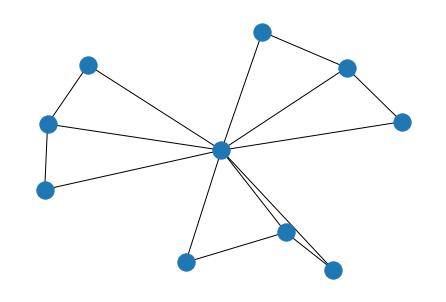

In [30]:
networkx.draw(g)

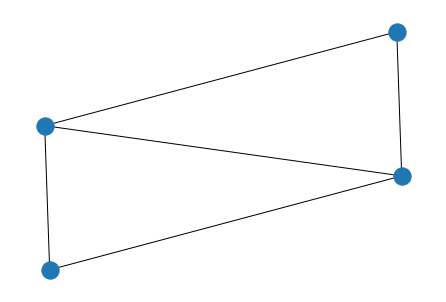

In [31]:
networkx.draw(subgraph)

In [34]:
path = nx.single_source_shortest_path(subgraph, -1)
path

{-1: [-1], 3: [-1, 3], 4: [-1, 4], 5: [-1, 5]}

In [39]:
length = list(nx.single_target_shortest_path_length(g, -1))

[(-1, 0),
 (0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1)]